In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def w_alpha(x, alpha):
    a = 2 - alpha
    b = alpha
    x = np.clip(x, 1e-12, 1-1e-12)
    return x**(a-1) * (1-x)**(b-1) / sp.beta(a, b)

def Q_jacobi(x, alpha, n):
    t = 2*x - 1
    return sp.jacobi(n-1, alpha-1, 1-alpha)(t)

def w_eps(x, alpha, n, eps):
    return (1 + eps * Q_jacobi(x, alpha, n)) * w_alpha(x, alpha)

def lambda_bk_numeric(b, k, alpha, N=2000):
    x = np.linspace(1e-9, 1-1e-9, N)
    w = w_alpha(x, alpha)
    integrand = x**(k-2) * (1-x)**(b-k) * w
    val = np.trapz(integrand, x)
    return max(val, 0.0)

def build_rates(n, alpha, forbid_star=True):
    r = {b: {} for b in range(2, n+1)}
    lam = {}
    for b in range(2, n+1):
        total = 0.0
        for k in range(2, b+1):
           # if forbid_star and (b > 2) and (k == b):
                #continue
            val = lambda_bk_numeric(b, k, alpha)
            r[b][k] = val
            total += val
        lam[b] = max(total, 1e-14)
    return r, lam

def simulate_tau(n, nsim, r, lam, rng):
    taus = np.empty(nsim)
    for s in range(nsim):
        b = n
        t = 0.0
        while b > 1:
            lb = lam[b]
            if lb <= 0:
                break
            t += rng.exponential(1.0 / lb)
            ks = list(r[b].keys())
            probs = np.array([r[b][k] for k in ks], float)
            tot = probs.sum()
            if tot == 0:
                break
            probs /= tot
            k = rng.choice(ks, p=probs)
            b = b - k + 1
        taus[s] = t
    return taus

In [3]:

# Parameters
alphas = [1.999,1.8,1.7,1.6,1.5,1.4,1.2, 1.0]
eps = 0.5
n = 10
nsim = 8000

results = []

for alpha in alphas:
    rng0 = np.random.default_rng(1234)
    rng1 = np.random.default_rng(5678)

    # same generator for Lambda0 and Lambda_eps (no star-merge)
    r0, lam0 = build_rates(n, alpha, forbid_star=True)

    taus0 = simulate_tau(n, nsim, r0, lam0, rng0)
    tause = simulate_tau(n, nsim, r0, lam0, rng1)

    results.append({
        "alpha": alpha,
        "eps": eps,
        "E_tau_Lambda0": taus0.mean(),
        "E_tau_Lambda_eps": tause.mean(),
        "Var_tau_Lambda0": taus0.var(),
        "Var_tau_Lambda_eps": tause.var()
    })

df = pd.DataFrame(results)
df


/tmp/ipykernel_89079/2412966882.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  val = np.trapz(integrand, x)


,alpha,eps,E_tau_Lambda0,E_tau_Lambda_eps,Var_tau_Lambda0,Var_tau_Lambda_eps
0,1.999,0.5,0.036758,0.036927,0.000148,0.000153
1,1.800,0.5,0.009716,0.009761,0.000010,0.000011
2,1.700,0.5,0.048877,0.049116,0.000263,0.000273
3,1.600,0.5,0.276433,0.277823,0.008710,0.008967
4,1.500,0.5,1.506627,1.515098,0.307242,0.310991
5,1.400,0.5,5.269446,5.279298,6.483605,6.434361
6,1.200,0.5,8.704767,8.573832,39.783344,39.383490
7,1.000,0.5,6.737432,6.719939,34.614859,33.670483


In [4]:
def build_R_matrix(n, r, lam):
    m = n - 1
    R = np.zeros((m, m))
    for b in range(2, n+1):
        i = b - 2
        R[i, i] = -lam[b]
        for k in r[b]:
            newb = b - k + 1
            if newb >= 2:
                j = newb - 2
                R[i, j] += r[b][k]
    return R

def density_from_R(R, t):
    m = len(R)
    p = np.zeros(m)
    p[-1] = 1.0  # départ: b=n
    ones = np.ones(m)
    dt = t[1] - t[0]
    f = np.zeros_like(t)
    for i in range(1, len(t)):
        k1 = p @ R
        k2 = (p + 0.5*dt*k1) @ R
        k3 = (p + 0.5*dt*k2) @ R
        k4 = (p + dt*k3) @ R
        p = p + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        f[i] = -(p @ (R @ ones))
    return np.clip(f, 0, None)

/tmp/ipykernel_89079/2412966882.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  val = np.trapz(integrand, x)


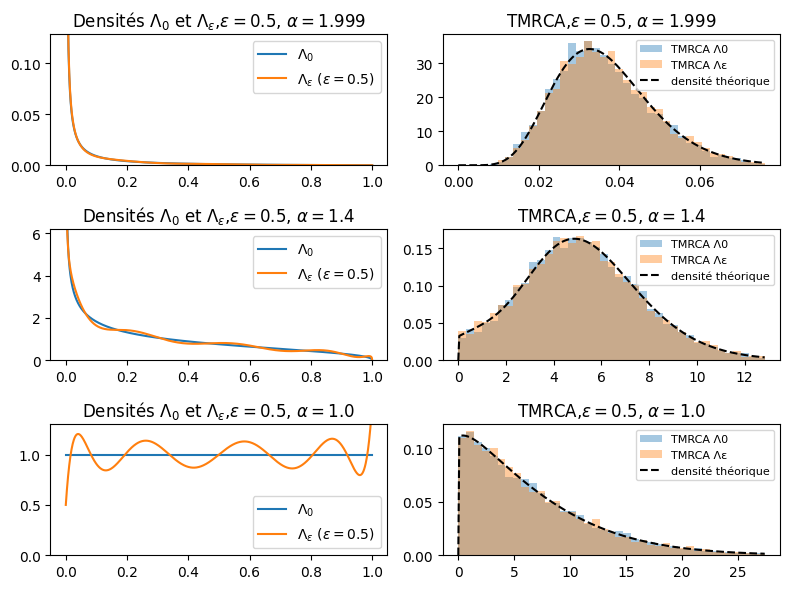

In [5]:
alphas_new = [1.999,1.4, 1.0]
x = np.linspace(0, 1, 800)

fig, axes = plt.subplots(len(alphas_new), 2, figsize=(8, 6))

for i, alpha in enumerate(alphas_new):
    axL = axes[i, 0]
    axR = axes[i, 1]

    # --- Lambda0 et Lambda_eps ---
    w0 = w_alpha(x, alpha)
    we = w_eps(x, alpha, n, eps)

    axL.plot(x, w0, label=r"$\Lambda_0$")
    axL.plot(x, we, label=rf"$\Lambda_\varepsilon$ ($\varepsilon={eps}$)")
    axL.set_ylim(0, np.quantile(w0, 0.99)*1.3)
    axL.set_title(fr"Densités $\Lambda_0$ et $\Lambda_\varepsilon$,$\varepsilon={eps}$, $\alpha={alpha}$")
    axL.legend()

    # --- simulation sans star-merge ---
    r0, lam0 = build_rates(n, alpha, forbid_star=True)
    R0 = build_R_matrix(n, r0, lam0)

    rng0 = np.random.default_rng(2025 + i)
    rng1 = np.random.default_rng(3000 + i)

    taus0 = simulate_tau(n, nsim, r0, lam0, rng0)
    tause = simulate_tau(n, nsim, r0, lam0, rng1)

    tmax = np.quantile(np.concatenate([taus0, tause]), 0.995)
    t = np.linspace(0, tmax, 300)
    f = density_from_R(R0, t)

    bins = np.linspace(0, tmax, 40)
    axR.hist(taus0, bins=bins, density=True, alpha=0.4, label="TMRCA Λ0")
    axR.hist(tause, bins=bins, density=True, alpha=0.4, label="TMRCA Λε")
    axR.plot(t, f, 'k--', lw=1.5, label="densité théorique")
    axR.set_title(fr"TMRCA,$\varepsilon={eps}$, $\alpha={alpha}$")
    axR.legend(fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
fig.savefig("LaTeX/photo/plot_foret_pas_gde_beta.svg")
fig.savefig("LaTeX/photo/plot_foret_pas_gde_beta.png", dpi=300)